In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
#trn_subjects = [1,2,3,4,5,6,7,8]
trn_subjects = [1, 2, 5, 6]

In [1]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet_mpf' #'gnet_mpf_general'
model_dir = '%s_%s' % (model_name, timestamp)

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/"
output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

NameError: name 'time' is not defined

# Load the stimuli images
From the subjectwise image preparation

In [7]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [9]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

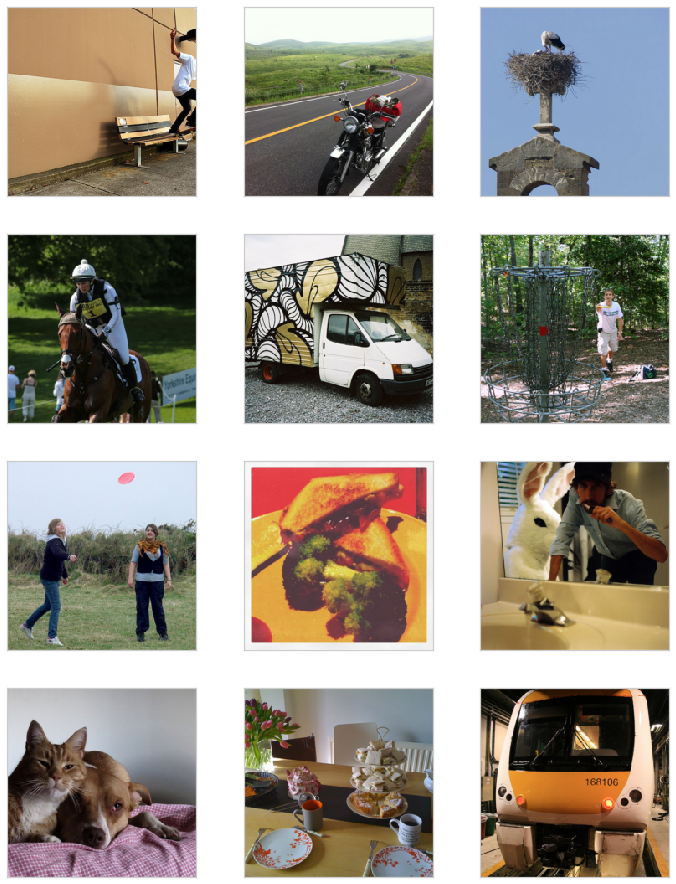

In [11]:
n = 1003
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [12]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [13]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    #voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    #ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    #voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 11838
2396 	: V1
2071 	: V2
1667 	: V3
712 	: hV4
945 	: V3ab
474 	: LO
2148 	: IPS
480 	: VO
374 	: PHC
281 	: MT
54 	: MST
236 	: other
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 10325
1630 	: V1
1523 	: V2
1565 	: V3
540 	: hV4
848 	: V3ab
503 	: LO
2196 	: IPS
431 	: VO
370 	: PHC
377 	: MT
35 	: MST
307 	: other
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 9565
1699 	: V1
1472 	: V2
1364 	: V3
719 	: hV4
708 	: V3ab
340 	: LO
1712 	: IPS
584 	: VO
418 	: PHC
269 	: MT
42 	: MST
238 	: other
--------  subject 6  -------
(85, 113, 83)
full mask length = 797215
selection length = 11827
1775 	: V1
1749 	: V2
1943 	: V3
876 	: hV4
880 	: V3ab
703 	: LO
2061 	: IPS
699 	: VO
489 	: PHC
349 	: MT
49 	: MST
254 	: other


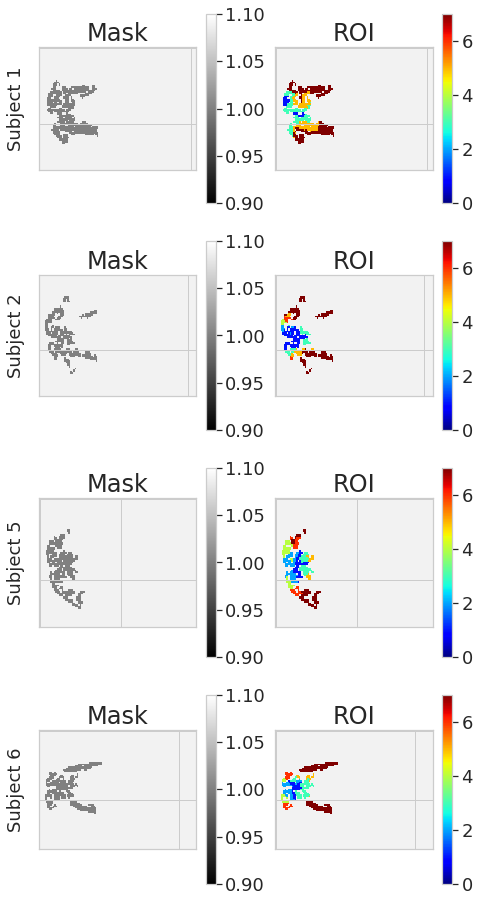

In [14]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    #volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    #plt.subplot(len(trn_subjects),3,3*k+3)
    #plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    #plt.title('NCSNR')
    #plt.colorbar()
    #_=plt.gca().set_xticklabels([])
    #_=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [18]:
#voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_set = h5py.File(root_dir+'voxel_data_general_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_1 = voxel_data_dict['voxel_data']
print (voxel_data_1.keys())

dict_keys(['1', '2', '5', '6'])


In [15]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part2.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_2 = voxel_data_dict['voxel_data']
print (voxel_data_2.keys())

dict_keys(['3', '4', '7', '8'])


In [16]:
voxel_data_1.update(voxel_data_2)
print (voxel_data_1.keys())

dict_keys(['1', '2', '5', '6', '3', '4', '7', '8'])


In [21]:
voxel_data = {}
for s in trn_subjects:
    roi_masks = list(iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names))
    roi_mask, roi_name = roi_masks[4]
    voxel_data['%s'%s] = voxel_data_1['%s'%s][:,roi_mask]
    print ("%s: %d \t: %s" % (s, np.sum(roi_mask), roi_name))

1: 945 	: V3ab
2: 848 	: V3ab
5: 708 	: V3ab
6: 880 	: V3ab


In [18]:
del voxel_data_1
del voxel_data_2

## Slow load from raw data

In [17]:
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general_part1', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 1  -------
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.986, <sigma> = 0.838
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.882, <sigma> = 0.782
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.066, <sigma> = 0.866
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.812, <sigma> = 0.752
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.948, <sigma> = 0.836
/home/

int16 -32768 32767 (750, 84, 106, 82)
<beta> = 0.846, <sigma> = 0.958
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 84, 106, 82)
<beta> = 0.990, <sigma> = 0.951
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 84, 106, 82)
<beta> = 0.794, <sigma> = 0.927
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.mat
int16 -32768 32767 (750, 84, 106, 82)
<beta> = 0.879, <sigma> = 0.925
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session07.mat
int16 -32768 32767 (750, 84, 106, 82)
<beta> = 0.789, <sigma> = 0.880
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session08.mat
int16 -32768 32767 (750, 84, 106, 8

<beta> = 1.664, <sigma> = 1.241
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.mat
int16 -32768 32767 (750, 78, 97, 79)
<beta> = 1.693, <sigma> = 1.215
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session07.mat
int16 -32768 32767 (750, 78, 97, 79)
<beta> = 1.622, <sigma> = 1.205
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session08.mat
int16 -32768 32767 (750, 78, 97, 79)
<beta> = 1.787, <sigma> = 1.252
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session09.mat
int16 -32768 32767 (750, 78, 97, 79)
<beta> = 1.665, <sigma> = 1.210
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj05/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session10.mat
int16 -32768 32767 (750, 78, 97, 79)
<beta> = 1.515, <sigma> = 1.165
/home/st

int16 -32768 32767 (750, 83, 113, 85)
<beta> = 1.062, <sigma> = 0.889
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session09.mat
int16 -32768 32767 (750, 83, 113, 85)
<beta> = 1.159, <sigma> = 0.877
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session10.mat
int16 -32768 32767 (750, 83, 113, 85)
<beta> = 1.259, <sigma> = 0.913
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session11.mat
int16 -32768 32767 (750, 83, 113, 85)
<beta> = 1.121, <sigma> = 0.841
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session12.mat
int16 -32768 32767 (750, 83, 113, 85)
<beta> = 1.350, <sigma> = 1.047
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj06/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session13.mat
int16 -32768 32767 (750, 83, 113, 8

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [22]:
from src.load_nsd import image_feature_fn, data_split

data_size, nnv = {}, {}
trn_stim_data, trn_voxel_data  = {}, {}
val_stim_single_trial_data, val_voxel_single_trial_data = {}, {}
val_stim_multi_trial_data, val_voxel_multi_trial_data = {}, {}

for k,s in enumerate(trn_subjects):
    data_size[s], nnv[s] = voxel_data['%s'%s].shape 
    print ('--------  subject %d  -------' % s)
    trn_stim_data[s], trn_voxel_data[s],\
    val_stim_single_trial_data[s], val_voxel_single_trial_data[s],\
    val_stim_multi_trial_data[s], val_voxel_multi_trial_data[s] = \
        data_split(image_feature_fn(image_data[s]), voxel_data['%s'%s], ordering, imagewise=False)

--------  subject 1  -------
Total number of voxels = 945
--------  subject 2  -------
Total number of voxels = 848
--------  subject 5  -------
Total number of voxels = 708
--------  subject 6  -------
Total number of voxels = 880


- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [23]:
del voxel_data
del image_data

In [24]:
trn_stim_mean = sum([np.mean(trn_stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47605687]]

  [[0.4519502 ]]

  [[0.41192448]]]]


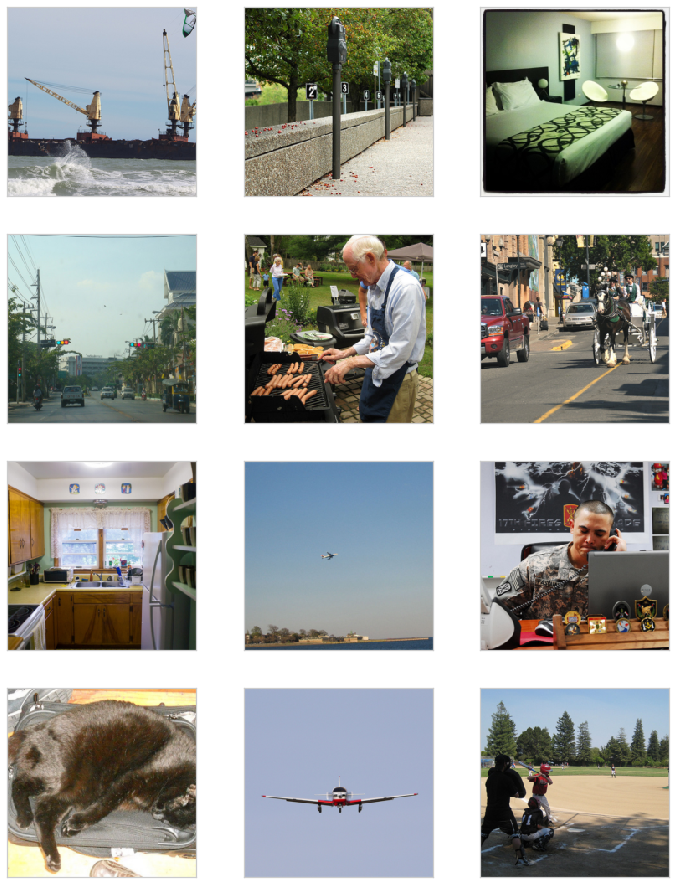

In [25]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(trn_stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Model

In [26]:
import src.torch_joint_training_sequences as aaa
import imp
imp.reload(aaa)

<module 'src.torch_joint_training_sequences' from '/home/styvesg/Documents/PostDoc/GitRepo/nsd/src/torch_joint_training_sequences.py'>

In [27]:
from src.torch_joint_training_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [30]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [31]:
shared_model = Encoder(trn_stim_mean, trunk_width=64).to(device)
rec, fmaps, h = shared_model(T.from_numpy(trn_stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

## Parameter count

In [32]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [945, 25, 25]   
block size [945, 13, 13]   
block size [945, 512]      
block size [945]           
--------- subject 2 ----------
block size [848, 25, 25]   
block size [848, 13, 13]   
block size [848, 512]      
block size [848]           
--------- subject 5 ----------
block size [708, 25, 25]   
block size [708, 13, 13]   
block size [708, 512]      
block size [708]           
--------- subject 6 ----------
block size [880, 25, 25]   
block size [880, 13, 13]   
block size [880, 512]      
block size [880]           

1034944 shared params
1613 approx params per voxels


## Load prefilters value

In [33]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

# Loss function, grad function, etc.

In [34]:
optimizer_net = optim.Adam([
        #{'params': shared_model.pre.parameters()},
        {'params': shared_model.enc.parameters()},
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
        {'params': sp.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [35]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    _err = T.sum((_r - _v)**2, dim=0)
    _loss = T.sum(_err)
    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

In [36]:
subj = trn_subjects[0]
print_grads(shared_model, subject_fwrfs[subj],
            shared_model.enc.parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])
print_grads(shared_model, subject_fwrfs[subj],
            subject_fwrfs[subj].parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])

[128, 192, 3, 3] : value=0.029772, grad=0.022582
[128]            : value=0.000000, grad=0.061032
[192]            : value=1.000000, grad=0.030458
[192]            : value=0.000000, grad=0.080475
[128, 128, 3, 3] : value=0.033360, grad=0.021211
[128]            : value=0.000000, grad=0.034032
[128]            : value=1.000000, grad=0.028340
[128]            : value=0.000000, grad=0.084049
[128, 128, 3, 3] : value=0.033215, grad=0.019158
[128]            : value=0.000000, grad=0.032743
[128]            : value=1.000000, grad=0.026020
[128]            : value=0.000000, grad=0.077806
[128, 128, 3, 3] : value=0.033226, grad=0.011290
[128]            : value=0.000000, grad=0.032495
[128]            : value=1.000000, grad=0.016653
[128]            : value=0.000000, grad=0.065830
[128, 128, 3, 3] : value=0.033153, grad=0.018233
[128]            : value=0.000000, grad=0.030312
[128]            : value=1.000000, grad=0.028047
[128]            : value=0.000000, grad=0.065936
[128, 128, 3, 3] : v

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [37]:
batch_size = 100
num_epochs = 50
holdout_size = 3000

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        trn_stim_data, trn_voxel_data,
        num_epochs=num_epochs, batch_size=batch_size, holdout_size=holdout_size, masks=None, randomize=False)

\ : 100.0 %
  Epoch 1 of 50 took       121.058s
  training loss:               0.980702
  holdout loss (batch):        0.973842
  Subject 1: median (max) validation accuracy = 0.118 (0.392)
  Subject 2: median (max) validation accuracy = 0.130 (0.377)
  Subject 5: median (max) validation accuracy = 0.171 (0.480)
  Subject 6: median (max) validation accuracy = 0.123 (0.356)
** Saving params with joint score = 0.132 **

\ : 100.0 %
  Epoch 2 of 50 took       122.199s
  training loss:               0.970327
  holdout loss (batch):        0.969811
  Subject 1: median (max) validation accuracy = 0.127 (0.413)
  Subject 2: median (max) validation accuracy = 0.141 (0.397)
  Subject 5: median (max) validation accuracy = 0.182 (0.488)
  Subject 6: median (max) validation accuracy = 0.133 (0.394)
** Saving params with joint score = 0.142 **

\ : 100.0 %
  Epoch 3 of 50 took       121.879s
  training loss:               0.966611
  holdout loss (batch):        0.966773
  Subject 1: median (max) va

  Subject 5: median (max) validation accuracy = 0.216 (0.512)
  Subject 6: median (max) validation accuracy = 0.170 (0.456)
** Saving params with joint score = 0.183 **

\ : 100.0 %
  Epoch 21 of 50 took       122.406s
  training loss:               0.944523
  holdout loss (batch):        0.950627
  Subject 1: median (max) validation accuracy = 0.176 (0.501)
  Subject 2: median (max) validation accuracy = 0.200 (0.532)
  Subject 5: median (max) validation accuracy = 0.215 (0.514)
  Subject 6: median (max) validation accuracy = 0.171 (0.461)
** Saving params with joint score = 0.184 **

\ : 100.0 %
  Epoch 22 of 50 took       122.970s
  training loss:               0.944284
  holdout loss (batch):        0.949475
  Subject 1: median (max) validation accuracy = 0.179 (0.499)
  Subject 2: median (max) validation accuracy = 0.199 (0.532)
  Subject 5: median (max) validation accuracy = 0.216 (0.511)
  Subject 6: median (max) validation accuracy = 0.171 (0.461)
** Saving params with joint sc

  Subject 1: median (max) validation accuracy = 0.181 (0.506)
  Subject 2: median (max) validation accuracy = 0.206 (0.536)
  Subject 5: median (max) validation accuracy = 0.219 (0.517)
  Subject 6: median (max) validation accuracy = 0.175 (0.470)
** Saving params with joint score = 0.189 **

\ : 100.0 %
  Epoch 42 of 50 took       122.764s
  training loss:               0.939391
  holdout loss (batch):        0.947329
  Subject 1: median (max) validation accuracy = 0.181 (0.505)
  Subject 2: median (max) validation accuracy = 0.204 (0.539)
  Subject 5: median (max) validation accuracy = 0.219 (0.517)
  Subject 6: median (max) validation accuracy = 0.175 (0.467)

\ : 100.0 %
  Epoch 43 of 50 took       122.724s
  training loss:               0.939015
  holdout loss (batch):        0.947396
  Subject 1: median (max) validation accuracy = 0.181 (0.504)
  Subject 2: median (max) validation accuracy = 0.206 (0.536)
  Subject 5: median (max) validation accuracy = 0.220 (0.517)
  Subject 6: 

# Results

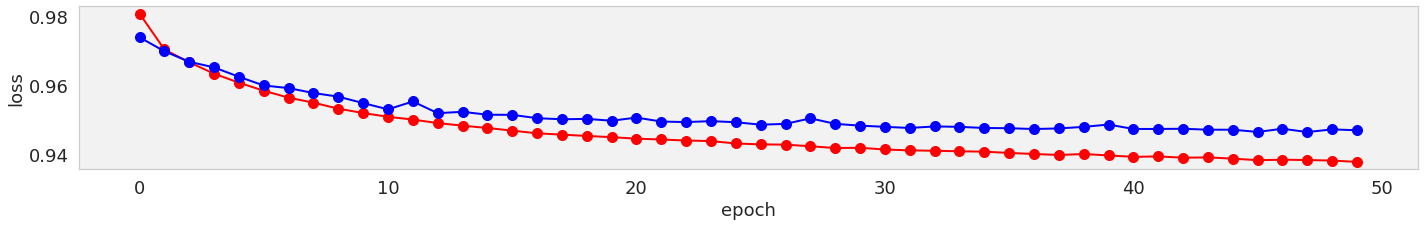

In [39]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

No handles with labels found to put in legend.


Text(0.5, 0, 'epoch')

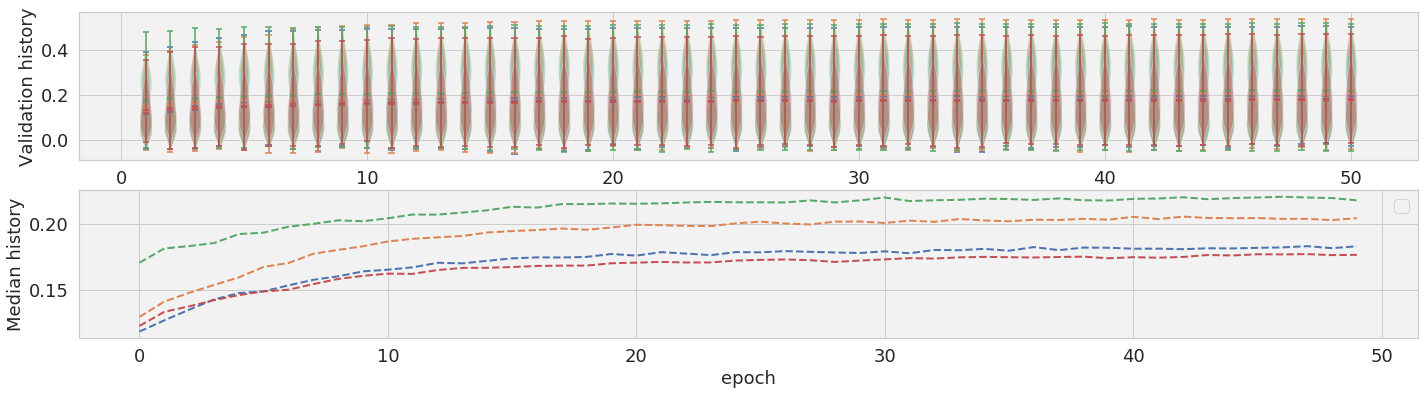

In [40]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [41]:
val_voxel = {s: val_voxel_single_trial_data[s] for s in val_voxel_single_trial_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 50
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, val_stim_single_trial_data, val_voxel, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.190
best joint val cc = 0.197
subject 1: val cc = 0.199
subject 2: val cc = 0.190
subject 5: val cc = 0.271
subject 6: val cc = 0.172


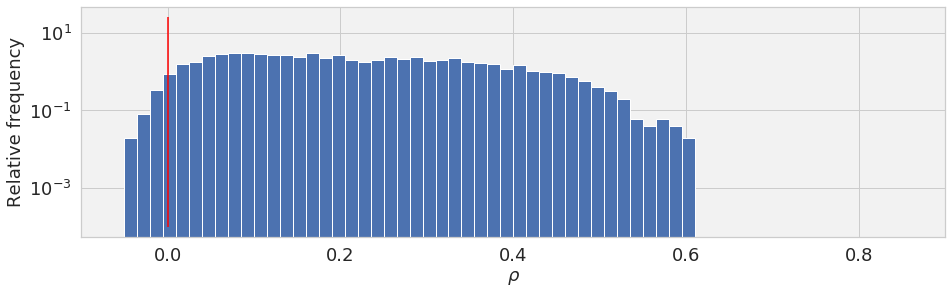

In [42]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [43]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_size': holdout_size,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, output_dir+'model_params')

In [44]:
f = open(output_dir+'model_notes.txt', "w+")
f.write( "Run on V3ab for a 8 subjects\n")
f.close()

In [45]:
n_resample = 64
subject_resample_val_cc = {}

for s in val_voxel_single_trial_data.keys():
    print ('sampling subject %d'%s)
    subject_resample_val_cc[s] = cc_resampling_with_replacement(_pred_fn, shared_model, subject_fwrfs[s], val_stim_single_trial_data[s], val_voxel_single_trial_data[s], batch_size, n_resample)

sampling subject 1


100%|██████████| 64/64 [00:08<00:00,  7.19it/s]


sampling subject 2


100%|██████████| 64/64 [00:07<00:00,  8.67it/s]


sampling subject 5


100%|██████████| 64/64 [00:06<00:00, 10.34it/s]


sampling subject 6


100%|██████████| 64/64 [00:07<00:00,  8.82it/s]


best_joint_cc_score: 0.190
score mean = 0.1975, std.dev = 0.0028
Subject 1 median cc mean = 0.1989, std.dev = 0.0041
Subject 2 median cc mean = 0.1894, std.dev = 0.0035
Subject 5 median cc mean = 0.2683, std.dev = 0.0070
Subject 6 median cc mean = 0.1746, std.dev = 0.0057


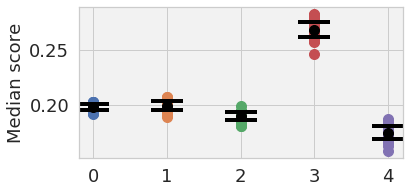

In [46]:
f = open(output_dir+'model_notes.txt', "a")
f.write( "-- median_validation_accuracies --\n")

print ('best_joint_cc_score: %.3f' % best_joint_cc_score)
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.60, right=.95, top=.95, wspace=0., hspace=0.)
val_score_samples = [np.median(np.concatenate([ccs[i] for s,ccs in subject_resample_val_cc.items()], axis=0))\
    for i in range(n_resample)]
print ('score mean = %.04f, std.dev = %.04f'% (np.mean(val_score_samples),  np.std(val_score_samples)))
f.write('score mean = %.04f, std.dev = %.04f\n'% (np.mean(val_score_samples),  np.std(val_score_samples)))
plt.plot([0,]*len(val_score_samples), val_score_samples, linestyle='None', marker='o', ms=10)
plt.errorbar(x=[0,], y=[np.mean(val_score_samples),], yerr=[np.std(val_score_samples),], marker='o',\
    color='k', ms=10, elinewidth=4,capsize=16, capthick=4)

for k,(s,ccs) in enumerate(subject_resample_val_cc.items()): 
    mcc = [np.median(cc) for cc in ccs]
    print ('Subject %s median cc mean = %.04f, std.dev = %.04f'% (s, np.mean(mcc), np.std(mcc)))
    f.write('Subject %s median cc mean = %.04f, std.dev = %.04f\n'% (s, np.mean(mcc), np.std(mcc)))
    plt.plot([k+1,]*len(mcc), mcc, linestyle='None', marker='o', ms=10)
    plt.errorbar(x=[k+1,], y=[np.mean(mcc),], yerr=[np.std(mcc),], marker='o',\
             color='k', ms=10, elinewidth=4,capsize=16, capthick=4)
    plt.ylabel('Median score') 
f.close()

In [47]:
filename = output_dir + 'median_validation_accuracies%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Subject-wise analysis

In [48]:
subj = 1 # for s in val_subjects
subject_dir = output_dir + 'S%02d/'%subj

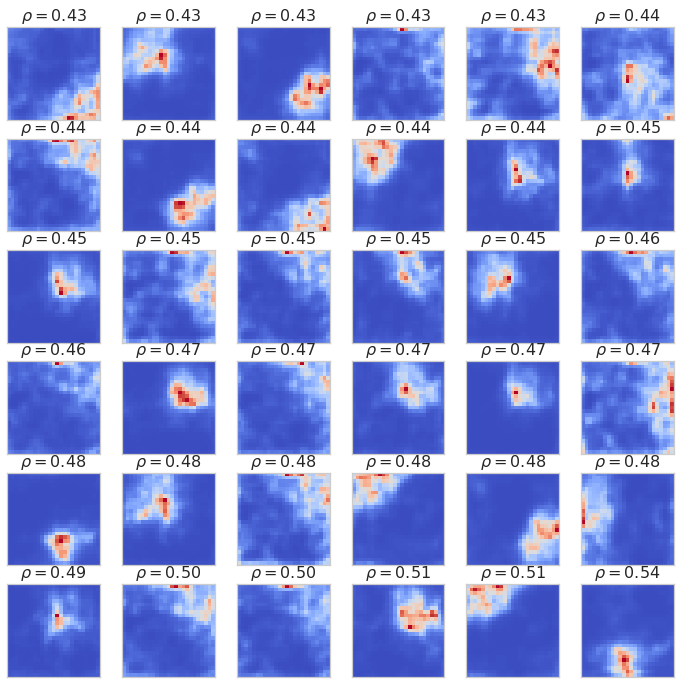

In [49]:
from matplotlib import cm
def pooling_fn(x):
    return np.exp(x) / np.sum(np.exp(x), axis=(1,2), keepdims=True)

vidxes = np.argsort(subject_val_cc[subj])
vox = vidxes[-36:] # np.arange(49) #
n_x = int(np.floor(np.sqrt(len(vox))))
n_y = int(np.ceil(len(vox)/n_x))+1
fig2a=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[0])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [50]:
filename = output_dir + 'S%02d/subj%02d_rf0_sample%s'  % (subj , subj, saveext)
fig2a.patch.set_alpha(0.)
fig2a.savefig(filename, **savearg)
plt.close()

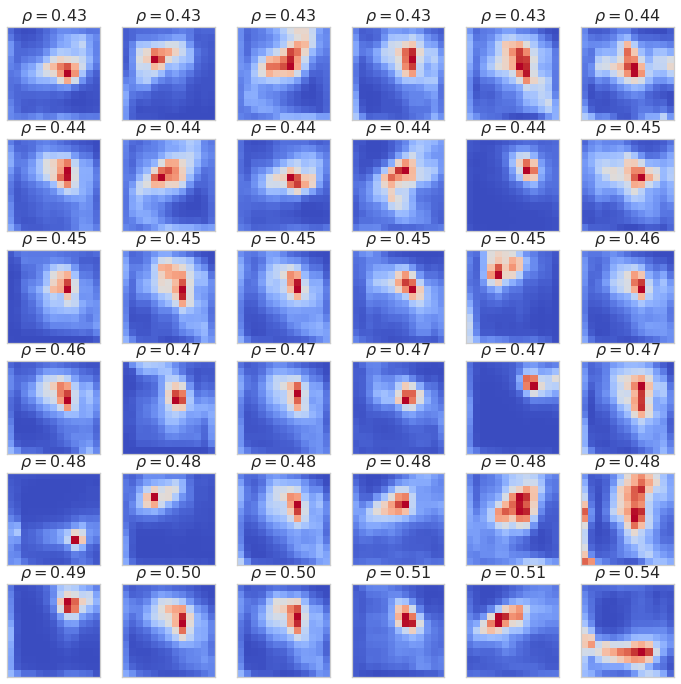

In [51]:
fig2b=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[1])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [52]:
filename = output_dir + 'S%02d/subj%02d_rf1_sample%s'  % (subj , subj, saveext)
fig2b.patch.set_alpha(0.)
fig2b.savefig(filename, **savearg)
plt.close()

---
# Compare to other models

In [53]:
file_timestamp_dir = {# the classic dnn-fwrf folders
    1: "Mar-27-2020_0301",
    2: "Apr-01-2020_0250",
    3: "Apr-25-2020_1550",
    4: "May-08-2020_2148",    
    5: "Mar-29-2020_2349",
    6: "Mar-31-2020_0220",
    7: "May-17-2020_1856",
    8: "May-18-2020_2148"
}

In [55]:
from src.plots import plot_fwrf_paper_compare
for subj in trn_subjects:
    pre_cc_volume  = load_mask_from_nii(root_dir+"output/S%02d/dnn_fwrf_%s/val_cc.nii" % (subj, file_timestamp_dir[subj]) )
    roi_masks = list(iterate_roi(group, voxel_roi[subj], roi_map, group_name=group_names))
    pre_cc = pre_cc_volume.flatten()[voxel_mask[subj]][roi_masks[4][0]]  

    fig3=plt.figure(figsize=(8, 8))
    fig3=plot_fwrf_paper_compare(pre_cc, subject_val_cc[subj], 0.055, [-.2, .2], [-.1, .9])
    ax=fig3.ax_joint
    ax.text(x=-.2+.01, y=.84, s='med = %.3f'%np.median(np.nan_to_num(subject_val_cc[subj])), fontsize=18)
    ax.text(x=-.2+.01, y=.77, s='max = %.3f'%np.max(np.nan_to_num(subject_val_cc[subj])), fontsize=18)
    ax.text(x=.2 - .13, y=.84, s='med = %.3f'%np.median(np.nan_to_num(pre_cc)), fontsize=18)
    ax.text(x=.2 - .13, y=.77, s='max = %.3f'%np.max(np.nan_to_num(pre_cc)), fontsize=18)
    plt.xlabel('this <--> reference')

    filename = output_dir + 'S%02d/subj%02d_model_advantage%s'  % (subj , subj, saveext)
    fig3.savefig(filename, **savearg)
    plt.close()

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

# SCALING

In [ ]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000 # [1,2,3,6,9,18,27]
#trn_trial = np.array([18,9,6,3,2,1,1])
holdout_perc = .2
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print (trn_sizes)
print (ho_sizes)

In [ ]:
batch_size = 100
num_epochs = 25
n_resample = 64
n_trial    = 4

characteristics = {'subjects': list(val_voxel_single_trial_data.keys()),
                   'trn_sizes': trn_sizes,
                   'n_resample': n_resample,
                   'n_trial': n_trial
                  }
for s in val_voxel_single_trial_data.keys():
    characteristics[s] = {'val_cc': len(val_stim_data)}

###
for k,(ts,hs) in enumerate(zip(trn_sizes[::-1], ho_sizes[::-1])):
    for t in range(n_trial):
        # initialize
        shared_model.load_state_dict(weight_init_value['enc'])
        optimizer_net.load_state_dict(weight_init_value['enc_opt'])
        for s,sd in subject_fwrfs.items():
            sd.load_state_dict(weight_init_value['fwrfs'][s])
            subject_optimizer[s].load_state_dict(weight_init_value['fwrfs_opt'][s])

        # training    
        best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
            learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_optimizer, 
                trn_stim_data, trn_voxel_data, num_epochs=num_epochs, 
                batch_size=batch_size, holdout_size=hs, trn_size=ts, masks=None, randomize=True)

        # validation   
        shared_model.load_state_dict(best_params['enc'])
        for s,sd in subject_fwrfs.items():
            sd.load_state_dict(best_params['fwrfs'][s])

        subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, 
                                     val_stim_single_trial_data, val_voxel_single_trial_data, batch_size)
        joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

        # uncertainty
        ccs, mccs = {}, {}
        for s in val_voxel_data.keys():
            ccs[s] = cc_resampling_with_replacement(_pred_fn, shared_model, subject_fwrfs[s], val_stim_single_trial_data[s], \
                                            val_voxel_single_trial_data[s], batch_size, n_resample)
            mccs[s] = [np.median(cc) for cc in ccs[s]]      

        # save
        for s in val_voxel_data.keys():
            characteristics[s]['run%d_trial%d'%(k,t)] = {'trn_size': min(ts, len(trn_stim_data[s])),
                              'hld_size': hs,
                              'best_epoch': best_epoch,
                              'val_samples': np.array(ccs[s]),
                              'median_val_samples': np.array(mccs[s]),
                              'val_cc': subject_val_cc[s]}
        # print a summary
        print ('================================================')
        print ('median cc = %.3f, max cc = %.3f' % (np.median(joined_val_cc), np.max(joined_val_cc)))
        print ('================================================')

In [ ]:
scaling_filepath = output_dir + "validation_accuracy_scaling"
print (scaling_filepath)

save_stuff(scaling_filepath, flatten_dict(characteristics))

In [ ]:
subj = trn_subjects[0]

actual_trn_size, result_cc, mean_median_cc, std_median_cc = [],[],[],[]
for k,ts in enumerate(trn_sizes): #characteristics['trn_size']
    cc_samples, cc_median_samples = [], []
    for t in range(characteristics['n_trial']):
        cc_samples += list(characteristics[subj]['run%d_trial%d'%(k,t)]['val_cc'])
        cc_median_samples += list(characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples'])
    actual_trn_size += [characteristics[subj]['run%d_trial%d'%(k,0)]['trn_size'],]
    result_cc += [np.copy(np.array(cc_samples)),]
    mean_median_cc += [np.mean(np.array(cc_median_samples))]
    std_median_cc += [np.std(np.array(cc_median_samples))] 

In [ ]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0.2, bottom=0.2, right=1., top=.98, wspace=0., hspace=0.)
plt.subplot(1,2,1)
for k,ts in enumerate(trn_sizes): #characteristics['trn_size']
    for t in range(characteristics['n_trial']):
        plt.plot([characteristics[subj]['run%d_trial%d'%(k,t)]['trn_size'],]*len(characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples']), 
                 characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples'],
                 color='b', marker='o', ms=10, alpha=.05)
plt.errorbar(actual_trn_size, mean_median_cc, std_median_cc, marker='.', ms=10, color='k', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Median validation accuracy')

In [ ]:
filename = output_dir + "median_validation_accuracy_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

In [ ]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot(actual_trn_size, mean_median_cc, color='r', lw=4, alpha=.5)
#plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
plt.violinplot(result_cc, positions=actual_trn_size, widths=np.array(actual_trn_size)*.3, showmedians=True)
#plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')

In [ ]:
filename = output_dir + "validation_distributions_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

---
# Model parameter reload

In [77]:
**
checkpoint = torch.load(output_dir + 'model_params')
print (checkpoint.keys())
best_params = checkpoint['best_params']

shared_model.pre.load_state_dict(best_params['pre'])
shared_model.enc.load_state_dict(best_params['enc'])
shared_model.eval()
#shared_model.dec.load_state_dict(best_params['dec'])
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval()

SyntaxError: invalid syntax (<ipython-input-77-9d809762fee1>, line 1)